In [3]:
!pip install kaggle
!kaggle datasets download -d alessiocorrado99/animals10 -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0




  0%|          | 0.00/586M [00:00<?, ?B/s]
 10%|#         | 59.0M/586M [00:00<00:00, 615MB/s]
 20%|##        | 119M/586M [00:00<00:00, 618MB/s] 
 30%|###       | 178M/586M [00:00<00:00, 612MB/s]
 40%|####      | 237M/586M [00:00<00:00, 605MB/s]
 51%|#####     | 297M/586M [00:00<00:00, 613MB/s]
 61%|######    | 356M/586M [00:00<00:00, 614MB/s]
 71%|#######1  | 416M/586M [00:00<00:00, 618MB/s]
 81%|########1 | 476M/586M [00:00<00:00, 619MB/s]
 92%|#########1| 536M/586M [00:00<00:00, 622MB/s]
100%|##########| 586M/586M [00:00<00:00, 617MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil, random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

2025-10-25 19:33:01.025901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-25 19:33:01.068463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-25 19:33:01.081398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-25 19:33:01.114615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 19:33:02.701341: W tensorflow/compiler/tf2

In [3]:
root = Path("data")
raw = root/"raw-img"

random.seed(44)

classes = [ d.name for d in raw.iterdir() if d.is_dir()]

classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [4]:
img_size = (224, 224)
btch_size = 8

train_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "data/raw-img",
    validation_split=0.3,
    subset="training",
    seed=2058,
    image_size=img_size,
    batch_size=btch_size,
    label_mode="categorical"
)

cv_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "data/raw-img",
    validation_split=0.3,
    subset="validation",            # <-- BẮT BUỘC có dòng này
    seed=2058,
    image_size=img_size,
    batch_size=btch_size,
    label_mode="categorical"
)

# tách nửa tập validation làm test
cv_batches = tf.data.experimental.cardinality(cv_dt)
test_dt = cv_dt.take(cv_batches // 2)
cv_dt   = cv_dt.skip(cv_batches // 2)

print("Tập train:", tf.data.experimental.cardinality(train_dt).numpy(), "batch")
print("Tập cv:",   tf.data.experimental.cardinality(cv_dt).numpy(), "batch")
print("Tập test:", tf.data.experimental.cardinality(test_dt).numpy(), "batch")

train_classes = train_dt.class_names


Found 26179 files belonging to 10 classes.
Using 18326 files for training.


I0000 00:00:1761395638.904033    1246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1761395639.360752    1246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1761395639.360912    1246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1761395639.366463    1246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1761395639.366640    1246 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 26179 files belonging to 10 classes.
Using 7853 files for validation.
Tập train: 2291 batch
Tập cv: 491 batch
Tập test: 491 batch


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dt = train_dt.shuffle(1000).prefetch(AUTOTUNE)
cv_dt   = cv_dt.prefetch(AUTOTUNE)
test_dt  = test_dt.prefetch(AUTOTUNE)

In [5]:
for images, labels in train_dt.take(1):
    plt.figure(figsize=(12, 6))
    class_names = train_classes   # danh sách tên lớp

    for i in range(5):  # hiển thị 5 ảnh đầu tiên
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        # Lấy chỉ số lớp thật
        class_index = tf.argmax(labels[i]).numpy()
        class_label = class_names[class_index]

        # Hiển thị label lên tiêu đề
        plt.title(f"{class_label}\n({class_index})")

        # In ra console (terminal)
        print(f"Ảnh {i+1}: chỉ số lớp = {class_index}, tên lớp = {class_label}")

    plt.show()


2025-10-25 19:09:53.523172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:09:54.278477: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:09:59.209853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 135 of 1000
2025-10-25 19:10:09.456246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:10:10.560638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:10:10.702673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:10:11.124503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:10:26.827494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (

ResourceExhaustedError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} data/raw-img/butterfly/OIP-YBPrC8bnUdgXuH62l4EIEAHaEK.jpeg; Cannot allocate memory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

In [6]:
# from tensorflow.keras import applications, models,optimizers, losses

# num_classes = 10

# # Tiền xử lý + Augment (ở tầng đầu vào)
# data_aug = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.05),
#     tf.keras.layers.RandomZoom(0.1),
# ])

# base = applications.ResNet50(
#     include_top=False, weights="imagenet", input_shape=img_size+(3,)
# )

# # applications.ResNet50	Gọi mô hình ResNet50 có sẵn trong tf.keras.applications, đã được huấn luyện trước trên ImageNet.
# # include_top=False	Bỏ phần fully connected cuối cùng (head) của ResNet — phần này dùng để phân loại 1000 lớp ImageNet. Khi bạn muốn dùng ResNet làm feature extractor, bạn bỏ phần này để thêm layer riêng của bạn sau đó.
# # weights="imagenet"	Nạp trọng số đã huấn luyện sẵn trên ImageNet, giúp mô hình biết nhận dạng đặc trưng ảnh tổng quát (đường, cạnh, texture, màu, …).
# # input_shape=img_size+(3,)	Đặt kích thước đầu vào cho ảnh, ví dụ img_size = (224, 224) → (224,224,3) cho ảnh màu RGB.

# base.trainable = False
# # Lệnh này đóng băng (freeze) tất cả các layer trong base.
# # Khi bạn huấn luyện mô hình mới, ResNet50 sẽ không thay đổi trọng số — chỉ phần “đầu” (fully connected mà bạn thêm sau) được huấn luyện.


# inputs = tf.keras.Input(shape=img_size+(3,))  #img_size+(3,) = (224,224,3) → ảnh màu RGB 224×224 pixel.
# x = data_aug(inputs)  # tạo thêm biến thể cho ảnh (lật, xoay, zoom nhẹ) để mô hình học tốt hơn, tránh overfit.

# x = applications.resnet.preprocess_input(x)  # ResNet yêu cầu ảnh đầu vào phải được chuẩn hóa theo một chuẩn riêng của ImageNet

# x = base(x, training=False)
# # Gọi mô hình ResNet50 (đã load trước đó) để trích xuất đặc trưng (feature extraction)
# # base ở đây chính là:
# #     base = tf.keras.applications.ResNet50(
# #         include_top=False, weights="imagenet", input_shape=img_size+(3,)
# #     )

# # training=False nghĩa là:
# # Các lớp BatchNorm trong ResNet sử dụng thống kê trung bình/độ lệch chuẩn đã lưu sẵn thay vì cập nhật mới.
# # Giúp giữ nguyên đặc trưng ImageNet, tránh thay đổi trong giai đoạn huấn luyện phần đầu.

# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
# model = models.Model(inputs, outputs)

# model.compile(
#     optimizer=optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary()


from tensorflow.keras import applications, models, optimizers

num_classes = 10

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

base = applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_size + (3,))
base.trainable = False

inputs = tf.keras.Input(shape=img_size + (3,))
x = data_aug(inputs)
x = applications.resnet.preprocess_input(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
from tensorflow.keras import optimizers

ckpt_dir = Path("models"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / "ResNet50_animals.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(ckpt_path),
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=False
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max"
    ),
]

history = model.fit(
    train_dt,
    validation_data=cv_dt,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("Đánh giá trên test:")
model.evaluate(test_dt, verbose=1)


Epoch 1/15


2025-10-25 19:35:08.543247: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:11.375523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:15.415457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 253 of 1000
2025-10-25 19:35:26.594876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:27.748747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:27.792765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:28.343041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:44.241951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (

  52/2291 ━━━━━━━━━━━━━━━━━━━━ 4:32 122ms/step - accuracy: 0.3533 - loss: 2.1560

2025-10-25 19:35:56.478581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  71/2291 ━━━━━━━━━━━━━━━━━━━━ 4:28 121ms/step - accuracy: 0.4118 - loss: 1.9494

2025-10-25 19:35:58.752802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:35:58.755096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  87/2291 ━━━━━━━━━━━━━━━━━━━━ 4:25 121ms/step - accuracy: 0.4520 - loss: 1.8122

2025-10-25 19:36:00.542860: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 531/2291 ━━━━━━━━━━━━━━━━━━━━ 3:29 119ms/step - accuracy: 0.7468 - loss: 0.8254

2025-10-25 19:36:53.508075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 615/2291 ━━━━━━━━━━━━━━━━━━━━ 3:19 119ms/step - accuracy: 0.7634 - loss: 0.7701

2025-10-25 19:37:03.431996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 993/2291 ━━━━━━━━━━━━━━━━━━━━ 2:34 119ms/step - accuracy: 0.8093 - loss: 0.6187

2025-10-25 19:37:48.329588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1012/2291 ━━━━━━━━━━━━━━━━━━━━ 2:32 119ms/step - accuracy: 0.8108 - loss: 0.6137

2025-10-25 19:37:50.630700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1056/2291 ━━━━━━━━━━━━━━━━━━━━ 2:27 119ms/step - accuracy: 0.8142 - loss: 0.6025

2025-10-25 19:37:55.896882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1215/2291 ━━━━━━━━━━━━━━━━━━━━ 2:08 120ms/step - accuracy: 0.8250 - loss: 0.5670

2025-10-25 19:38:15.664301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1524/2291 ━━━━━━━━━━━━━━━━━━━━ 1:31 120ms/step - accuracy: 0.8409 - loss: 0.5148

W0000 00:00:1761395932.910423    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.913434    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.915841    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.918614    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.921360    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.924756    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.928234    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.931516    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395932.947748    1369 gp

1525/2291 ━━━━━━━━━━━━━━━━━━━━ 1:32 121ms/step - accuracy: 0.8410 - loss: 0.5147

W0000 00:00:1761395933.979210    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395933.982539    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395933.985841    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395933.989175    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395933.991791    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395933.996434    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395934.006450    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395934.016119    1369 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761395934.051517    1369 gp

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8653 - loss: 0.4364

2025-10-25 19:40:37.707082: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:40:38.986240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:40:40.731070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:40:46.598808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:01.146371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:03.947361: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
W0000 00:00:1761396082.192739    1364 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761396082.195728    1364 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1761396082.198169    1364 gpu_timer.cc:114] Skipping

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 393s 147ms/step - accuracy: 0.9177 - loss: 0.2718 - val_accuracy: 0.9394 - val_loss: 0.2368
Epoch 2/15


2025-10-25 19:41:28.311216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:29.149584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:34.406826: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:35.540626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:35.949365: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:36.643778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:37.044701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 801 of 1000
2025-10-25 19:41:39.518767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  73/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 119ms/step - accuracy: 0.9385 - loss: 0.1768

2025-10-25 19:41:48.230174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:41:48.341685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  81/2291 ━━━━━━━━━━━━━━━━━━━━ 4:22 119ms/step - accuracy: 0.9383 - loss: 0.1771

2025-10-25 19:41:49.267630: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 113/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 118ms/step - accuracy: 0.9394 - loss: 0.1739

2025-10-25 19:41:53.023880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 533/2291 ━━━━━━━━━━━━━━━━━━━━ 3:27 118ms/step - accuracy: 0.9436 - loss: 0.1854

2025-10-25 19:42:42.553145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 622/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 118ms/step - accuracy: 0.9440 - loss: 0.1860

2025-10-25 19:42:53.337727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1017/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 118ms/step - accuracy: 0.9452 - loss: 0.1873

2025-10-25 19:43:39.678995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1021/2291 ━━━━━━━━━━━━━━━━━━━━ 2:29 118ms/step - accuracy: 0.9452 - loss: 0.1872

2025-10-25 19:43:40.043857: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1088/2291 ━━━━━━━━━━━━━━━━━━━━ 2:21 118ms/step - accuracy: 0.9454 - loss: 0.1869

2025-10-25 19:43:47.964749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1235/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 118ms/step - accuracy: 0.9458 - loss: 0.1859

2025-10-25 19:44:05.732915: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9465 - loss: 0.1849

2025-10-25 19:46:12.344264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:46:12.530144: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:46:13.414290: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:46:19.481579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:46:36.087898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:46:36.981510: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 331s 139ms/step - accuracy: 0.9472 - loss: 0.1876 - val_accuracy: 0.9518 - val_loss: 0.2096
Epoch 3/15


2025-10-25 19:46:59.316310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:47:00.206729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:47:05.384360: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:47:06.528198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:47:06.563046: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:47:07.399481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:47:08.249068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 810 of 1000
2025-10-25 19:47:10.392051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  74/2291 ━━━━━━━━━━━━━━━━━━━━ 4:20 117ms/step - accuracy: 0.9434 - loss: 0.1463

2025-10-25 19:47:19.214299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  81/2291 ━━━━━━━━━━━━━━━━━━━━ 4:20 118ms/step - accuracy: 0.9449 - loss: 0.1465

2025-10-25 19:47:20.021714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 107/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 118ms/step - accuracy: 0.9486 - loss: 0.1468

2025-10-25 19:47:23.107867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 112/2291 ━━━━━━━━━━━━━━━━━━━━ 4:16 118ms/step - accuracy: 0.9489 - loss: 0.1467

2025-10-25 19:47:23.610038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 550/2291 ━━━━━━━━━━━━━━━━━━━━ 3:26 119ms/step - accuracy: 0.9560 - loss: 0.1458

2025-10-25 19:48:15.746177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 634/2291 ━━━━━━━━━━━━━━━━━━━━ 3:16 119ms/step - accuracy: 0.9560 - loss: 0.1473

2025-10-25 19:48:25.558711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1030/2291 ━━━━━━━━━━━━━━━━━━━━ 2:29 118ms/step - accuracy: 0.9561 - loss: 0.1507

2025-10-25 19:49:12.523225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1036/2291 ━━━━━━━━━━━━━━━━━━━━ 2:28 118ms/step - accuracy: 0.9561 - loss: 0.1508

2025-10-25 19:49:13.139354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1072/2291 ━━━━━━━━━━━━━━━━━━━━ 2:24 118ms/step - accuracy: 0.9561 - loss: 0.1510

2025-10-25 19:49:17.555336: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1241/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 119ms/step - accuracy: 0.9561 - loss: 0.1521

2025-10-25 19:49:37.785975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9560 - loss: 0.1579

2025-10-25 19:51:41.630203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:51:42.270624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:51:43.955443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:51:51.163443: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:05.293873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:07.101876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 330s 138ms/step - accuracy: 0.9560 - loss: 0.1663 - val_accuracy: 0.9610 - val_loss: 0.1900
Epoch 4/15


2025-10-25 19:52:28.806931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:29.722644: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:35.020426: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:35.954354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:36.248677: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:36.671851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:52:37.668060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 836 of 1000
2025-10-25 19:52:39.304421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  77/2291 ━━━━━━━━━━━━━━━━━━━━ 4:29 122ms/step - accuracy: 0.9461 - loss: 0.2454

2025-10-25 19:52:48.768342: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  92/2291 ━━━━━━━━━━━━━━━━━━━━ 4:26 121ms/step - accuracy: 0.9471 - loss: 0.2385

2025-10-25 19:52:50.627321: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  96/2291 ━━━━━━━━━━━━━━━━━━━━ 4:25 121ms/step - accuracy: 0.9473 - loss: 0.2368

2025-10-25 19:52:51.098033: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 120/2291 ━━━━━━━━━━━━━━━━━━━━ 4:21 121ms/step - accuracy: 0.9483 - loss: 0.2272

2025-10-25 19:52:53.850252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 551/2291 ━━━━━━━━━━━━━━━━━━━━ 3:27 119ms/step - accuracy: 0.9567 - loss: 0.1679

2025-10-25 19:53:45.255044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 635/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 119ms/step - accuracy: 0.9569 - loss: 0.1656

2025-10-25 19:53:55.268854: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1019/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 119ms/step - accuracy: 0.9576 - loss: 0.1587

2025-10-25 19:54:41.174948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1051/2291 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - accuracy: 0.9576 - loss: 0.1583

2025-10-25 19:54:44.904673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1078/2291 ━━━━━━━━━━━━━━━━━━━━ 2:24 119ms/step - accuracy: 0.9576 - loss: 0.1580

2025-10-25 19:54:48.222080: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1239/2291 ━━━━━━━━━━━━━━━━━━━━ 2:05 120ms/step - accuracy: 0.9577 - loss: 0.1566

2025-10-25 19:55:07.584487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9581 - loss: 0.1526

2025-10-25 19:57:12.548256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:57:13.039543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:57:13.898255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:57:21.345840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:57:35.494153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:57:38.105417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 331s 139ms/step - accuracy: 0.9593 - loss: 0.1424 - val_accuracy: 0.9633 - val_loss: 0.1953
Epoch 5/15


2025-10-25 19:58:00.158101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:58:01.091030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:58:06.479897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:58:07.632974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:58:07.717465: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:58:08.530590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 19:58:08.997587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 783 of 1000
2025-10-25 19:58:11.498013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  70/2291 ━━━━━━━━━━━━━━━━━━━━ 4:30 122ms/step - accuracy: 0.9594 - loss: 0.1585

2025-10-25 19:58:20.253995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  77/2291 ━━━━━━━━━━━━━━━━━━━━ 4:29 122ms/step - accuracy: 0.9590 - loss: 0.1600

2025-10-25 19:58:21.080696: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  99/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 121ms/step - accuracy: 0.9586 - loss: 0.1611

2025-10-25 19:58:23.677457: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 101/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 121ms/step - accuracy: 0.9586 - loss: 0.1610

2025-10-25 19:58:23.913716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 541/2291 ━━━━━━━━━━━━━━━━━━━━ 3:29 120ms/step - accuracy: 0.9538 - loss: 0.1711

2025-10-25 19:59:16.509916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 637/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 120ms/step - accuracy: 0.9540 - loss: 0.1697

2025-10-25 19:59:27.925222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1041/2291 ━━━━━━━━━━━━━━━━━━━━ 2:29 120ms/step - accuracy: 0.9545 - loss: 0.1659

2025-10-25 20:00:16.389432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1047/2291 ━━━━━━━━━━━━━━━━━━━━ 2:28 120ms/step - accuracy: 0.9546 - loss: 0.1658

2025-10-25 20:00:17.096923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1072/2291 ━━━━━━━━━━━━━━━━━━━━ 2:25 120ms/step - accuracy: 0.9546 - loss: 0.1655

2025-10-25 20:00:20.082409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1240/2291 ━━━━━━━━━━━━━━━━━━━━ 2:05 120ms/step - accuracy: 0.9551 - loss: 0.1639

2025-10-25 20:00:39.916049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9564 - loss: 0.1600

2025-10-25 20:02:44.768583: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:02:45.272284: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:02:46.026466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:02:53.082868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:08.062722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:11.024422: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 329s 138ms/step - accuracy: 0.9564 - loss: 0.1621 - val_accuracy: 0.9587 - val_loss: 0.2253
Epoch 6/15


2025-10-25 20:03:28.762238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:29.520572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:34.488811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:35.376910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:35.411893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:36.262577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:37.397052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 841 of 1000
2025-10-25 20:03:39.019446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  76/2291 ━━━━━━━━━━━━━━━━━━━━ 4:27 121ms/step - accuracy: 0.9573 - loss: 0.1472

2025-10-25 20:03:48.255009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  90/2291 ━━━━━━━━━━━━━━━━━━━━ 4:25 121ms/step - accuracy: 0.9566 - loss: 0.1486

2025-10-25 20:03:49.937390: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:03:49.941613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 104/2291 ━━━━━━━━━━━━━━━━━━━━ 4:23 120ms/step - accuracy: 0.9565 - loss: 0.1486

2025-10-25 20:03:51.593715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 547/2291 ━━━━━━━━━━━━━━━━━━━━ 3:27 119ms/step - accuracy: 0.9598 - loss: 0.1417

2025-10-25 20:04:44.270356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 650/2291 ━━━━━━━━━━━━━━━━━━━━ 3:15 119ms/step - accuracy: 0.9599 - loss: 0.1427

2025-10-25 20:04:56.685590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1020/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 119ms/step - accuracy: 0.9600 - loss: 0.1432

2025-10-25 20:05:40.313630: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1063/2291 ━━━━━━━━━━━━━━━━━━━━ 2:26 119ms/step - accuracy: 0.9600 - loss: 0.1432

2025-10-25 20:05:45.502504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1076/2291 ━━━━━━━━━━━━━━━━━━━━ 2:24 119ms/step - accuracy: 0.9600 - loss: 0.1432

2025-10-25 20:05:47.052115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1247/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 119ms/step - accuracy: 0.9600 - loss: 0.1433

2025-10-25 20:06:07.512929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9601 - loss: 0.1433

2025-10-25 20:08:11.133415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:08:11.827290: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:08:12.239470: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 8389120 bytes after encountering the first element of size 8389120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-25 20:08:13.574972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:08:19.039824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:08:33.945807: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:08:36.623075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning:

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 327s 137ms/step - accuracy: 0.9617 - loss: 0.1421 - val_accuracy: 0.9506 - val_loss: 0.2428
Epoch 7/15


2025-10-25 20:08:55.282895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:08:56.194318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:09:01.417680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:09:02.351498: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:09:02.367456: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:09:03.004432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:09:04.112454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 858 of 1000
2025-10-25 20:09:05.515246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  82/2291 ━━━━━━━━━━━━━━━━━━━━ 4:29 122ms/step - accuracy: 0.9362 - loss: 0.2465

2025-10-25 20:09:15.578673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  88/2291 ━━━━━━━━━━━━━━━━━━━━ 4:28 122ms/step - accuracy: 0.9373 - loss: 0.2412

2025-10-25 20:09:16.306397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  95/2291 ━━━━━━━━━━━━━━━━━━━━ 4:27 122ms/step - accuracy: 0.9384 - loss: 0.2358

2025-10-25 20:09:17.241243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 111/2291 ━━━━━━━━━━━━━━━━━━━━ 4:23 121ms/step - accuracy: 0.9402 - loss: 0.2263

2025-10-25 20:09:19.098831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 545/2291 ━━━━━━━━━━━━━━━━━━━━ 3:26 119ms/step - accuracy: 0.9535 - loss: 0.1601

2025-10-25 20:10:10.152000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 633/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 119ms/step - accuracy: 0.9544 - loss: 0.1561

2025-10-25 20:10:20.815497: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1025/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 119ms/step - accuracy: 0.9567 - loss: 0.1480

2025-10-25 20:11:07.178431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1027/2291 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - accuracy: 0.9568 - loss: 0.1480

2025-10-25 20:11:07.410782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1077/2291 ━━━━━━━━━━━━━━━━━━━━ 2:23 118ms/step - accuracy: 0.9570 - loss: 0.1476

2025-10-25 20:11:13.275391: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1240/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 119ms/step - accuracy: 0.9575 - loss: 0.1465

2025-10-25 20:11:32.743646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9591 - loss: 0.1434

2025-10-25 20:13:37.767576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:13:38.531863: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:13:39.142630: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 8389120 bytes after encountering the first element of size 8389120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-25 20:13:39.567727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:13:46.048952: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:01.054288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:03.248908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning:

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 327s 138ms/step - accuracy: 0.9611 - loss: 0.1424 - val_accuracy: 0.9620 - val_loss: 0.2251
Epoch 8/15


2025-10-25 20:14:22.587109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:23.793072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:28.689182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:29.776559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:29.857861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:30.484513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:14:31.469962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 845 of 1000
2025-10-25 20:14:32.988048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-10-25 20:14:32.98828

  84/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 120ms/step - accuracy: 0.9634 - loss: 0.1234

2025-10-25 20:14:43.190764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  87/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 120ms/step - accuracy: 0.9634 - loss: 0.1243

2025-10-25 20:14:43.544736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  95/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 120ms/step - accuracy: 0.9634 - loss: 0.1259

2025-10-25 20:14:44.538414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 123/2291 ━━━━━━━━━━━━━━━━━━━━ 4:20 120ms/step - accuracy: 0.9630 - loss: 0.1350

2025-10-25 20:14:47.899528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 546/2291 ━━━━━━━━━━━━━━━━━━━━ 3:28 119ms/step - accuracy: 0.9651 - loss: 0.1349

2025-10-25 20:15:38.261533: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 640/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 119ms/step - accuracy: 0.9652 - loss: 0.1345

2025-10-25 20:15:49.521012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1018/2291 ━━━━━━━━━━━━━━━━━━━━ 2:32 120ms/step - accuracy: 0.9658 - loss: 0.1313

2025-10-25 20:16:34.890768: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1032/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 120ms/step - accuracy: 0.9658 - loss: 0.1312

2025-10-25 20:16:36.609881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1078/2291 ━━━━━━━━━━━━━━━━━━━━ 2:25 120ms/step - accuracy: 0.9658 - loss: 0.1310

2025-10-25 20:16:41.985845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1245/2291 ━━━━━━━━━━━━━━━━━━━━ 2:05 120ms/step - accuracy: 0.9656 - loss: 0.1312

2025-10-25 20:17:02.315237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9650 - loss: 0.1339

2025-10-25 20:19:08.390833: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:19:09.154716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:19:11.115697: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:19:17.150160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:19:32.293348: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:19:35.886018: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 331s 140ms/step - accuracy: 0.9647 - loss: 0.1367 - val_accuracy: 0.9628 - val_loss: 0.2417
Epoch 9/15


2025-10-25 20:19:54.066818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:19:54.980598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:20:00.284820: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:20:01.196856: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:20:01.222145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:20:02.110545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:20:02.869186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 817 of 1000
2025-10-25 20:20:04.555239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  78/2291 ━━━━━━━━━━━━━━━━━━━━ 4:28 121ms/step - accuracy: 0.9505 - loss: 0.1787

2025-10-25 20:20:14.188870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  88/2291 ━━━━━━━━━━━━━━━━━━━━ 4:28 122ms/step - accuracy: 0.9516 - loss: 0.1754

2025-10-25 20:20:15.353952: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  98/2291 ━━━━━━━━━━━━━━━━━━━━ 4:27 122ms/step - accuracy: 0.9525 - loss: 0.1721

2025-10-25 20:20:16.670757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 100/2291 ━━━━━━━━━━━━━━━━━━━━ 4:27 122ms/step - accuracy: 0.9527 - loss: 0.1716

2025-10-25 20:20:16.910322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 549/2291 ━━━━━━━━━━━━━━━━━━━━ 3:34 123ms/step - accuracy: 0.9623 - loss: 0.1451

2025-10-25 20:21:12.196427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 632/2291 ━━━━━━━━━━━━━━━━━━━━ 3:26 124ms/step - accuracy: 0.9625 - loss: 0.1445

2025-10-25 20:21:23.311611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1017/2291 ━━━━━━━━━━━━━━━━━━━━ 2:37 124ms/step - accuracy: 0.9636 - loss: 0.1405

2025-10-25 20:22:10.275415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1023/2291 ━━━━━━━━━━━━━━━━━━━━ 2:36 124ms/step - accuracy: 0.9636 - loss: 0.1404

2025-10-25 20:22:11.117155: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1082/2291 ━━━━━━━━━━━━━━━━━━━━ 2:28 123ms/step - accuracy: 0.9637 - loss: 0.1399

2025-10-25 20:22:17.825811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1243/2291 ━━━━━━━━━━━━━━━━━━━━ 2:08 123ms/step - accuracy: 0.9640 - loss: 0.1383

2025-10-25 20:22:37.189731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9650 - loss: 0.1352

2025-10-25 20:24:41.102745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:24:41.626369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:24:42.195123: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 8389120 bytes after encountering the first element of size 8389120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-25 20:24:43.260852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:24:48.903115: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:03.926653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:06.113543: W tensorflow/core/lib/png/png_io.cc:89] PNG warning:

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 344s 145ms/step - accuracy: 0.9663 - loss: 0.1342 - val_accuracy: 0.9638 - val_loss: 0.2329
Epoch 10/15


2025-10-25 20:25:37.887790: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:38.866592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:44.588065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:45.509524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:45.803047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:46.528198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:25:46.700698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 782 of 1000
2025-10-25 20:25:49.138150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  74/2291 ━━━━━━━━━━━━━━━━━━━━ 4:26 120ms/step - accuracy: 0.9824 - loss: 0.0959

2025-10-25 20:25:58.055982: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  86/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 120ms/step - accuracy: 0.9806 - loss: 0.1017

2025-10-25 20:25:59.482415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  99/2291 ━━━━━━━━━━━━━━━━━━━━ 4:22 120ms/step - accuracy: 0.9794 - loss: 0.1045

2025-10-25 20:26:00.988656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 110/2291 ━━━━━━━━━━━━━━━━━━━━ 4:21 120ms/step - accuracy: 0.9790 - loss: 0.1051

2025-10-25 20:26:02.375737: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 549/2291 ━━━━━━━━━━━━━━━━━━━━ 3:28 120ms/step - accuracy: 0.9683 - loss: 0.1264

2025-10-25 20:26:55.015418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 639/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 120ms/step - accuracy: 0.9676 - loss: 0.1286

2025-10-25 20:27:05.715305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1022/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 119ms/step - accuracy: 0.9664 - loss: 0.1315

2025-10-25 20:27:50.880970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1033/2291 ━━━━━━━━━━━━━━━━━━━━ 2:29 119ms/step - accuracy: 0.9664 - loss: 0.1315

2025-10-25 20:27:52.061073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1094/2291 ━━━━━━━━━━━━━━━━━━━━ 2:22 119ms/step - accuracy: 0.9664 - loss: 0.1315

2025-10-25 20:27:59.537816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1252/2291 ━━━━━━━━━━━━━━━━━━━━ 2:03 119ms/step - accuracy: 0.9662 - loss: 0.1316

2025-10-25 20:28:18.288980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9659 - loss: 0.1312

2025-10-25 20:30:21.043149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:30:21.473828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:30:22.634002: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:30:29.201754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:30:44.927352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:30:46.455627: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 341s 143ms/step - accuracy: 0.9651 - loss: 0.1357 - val_accuracy: 0.9671 - val_loss: 0.2252
Epoch 11/15


2025-10-25 20:31:18.705672: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:31:19.613073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:31:24.741463: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:31:25.493596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:31:25.949587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:31:26.413496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:31:27.387474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 834 of 1000
2025-10-25 20:31:29.049610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  71/2291 ━━━━━━━━━━━━━━━━━━━━ 4:20 117ms/step - accuracy: 0.9785 - loss: 0.0966

2025-10-25 20:31:37.330526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  89/2291 ━━━━━━━━━━━━━━━━━━━━ 4:18 117ms/step - accuracy: 0.9763 - loss: 0.0989

2025-10-25 20:31:39.565401: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  95/2291 ━━━━━━━━━━━━━━━━━━━━ 4:19 118ms/step - accuracy: 0.9758 - loss: 0.0993

2025-10-25 20:31:40.325094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 115/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 118ms/step - accuracy: 0.9747 - loss: 0.0990

2025-10-25 20:31:42.715052: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 546/2291 ━━━━━━━━━━━━━━━━━━━━ 3:26 118ms/step - accuracy: 0.9719 - loss: 0.0989

2025-10-25 20:32:33.555198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 639/2291 ━━━━━━━━━━━━━━━━━━━━ 3:15 118ms/step - accuracy: 0.9718 - loss: 0.0993

2025-10-25 20:32:44.660648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1020/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 118ms/step - accuracy: 0.9712 - loss: 0.1013

2025-10-25 20:33:29.827158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1027/2291 ━━━━━━━━━━━━━━━━━━━━ 2:29 118ms/step - accuracy: 0.9712 - loss: 0.1014

2025-10-25 20:33:30.640552: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1076/2291 ━━━━━━━━━━━━━━━━━━━━ 2:23 118ms/step - accuracy: 0.9712 - loss: 0.1017

2025-10-25 20:33:36.362496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1242/2291 ━━━━━━━━━━━━━━━━━━━━ 2:03 118ms/step - accuracy: 0.9711 - loss: 0.1025

2025-10-25 20:33:55.880658: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9702 - loss: 0.1086

2025-10-25 20:35:58.288088: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:35:58.909727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:35:59.805134: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:05.956383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:22.151562: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:23.934742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 324s 136ms/step - accuracy: 0.9686 - loss: 0.1192 - val_accuracy: 0.9646 - val_loss: 0.2367
Epoch 12/15


2025-10-25 20:36:42.650125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:43.525077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:49.227343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:50.135802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:50.230540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:50.999111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:36:51.550034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 787 of 1000
2025-10-25 20:36:53.566549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  78/2291 ━━━━━━━━━━━━━━━━━━━━ 4:19 117ms/step - accuracy: 0.9655 - loss: 0.1090

2025-10-25 20:37:02.750440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  84/2291 ━━━━━━━━━━━━━━━━━━━━ 4:19 118ms/step - accuracy: 0.9654 - loss: 0.1095

2025-10-25 20:37:03.462714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  90/2291 ━━━━━━━━━━━━━━━━━━━━ 4:18 118ms/step - accuracy: 0.9654 - loss: 0.1100

2025-10-25 20:37:04.158142: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  97/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 117ms/step - accuracy: 0.9655 - loss: 0.1103

2025-10-25 20:37:04.977603: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 545/2291 ━━━━━━━━━━━━━━━━━━━━ 3:30 120ms/step - accuracy: 0.9648 - loss: 0.1303

2025-10-25 20:37:59.219451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 633/2291 ━━━━━━━━━━━━━━━━━━━━ 3:19 120ms/step - accuracy: 0.9645 - loss: 0.1342

2025-10-25 20:38:09.848081: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1025/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - accuracy: 0.9639 - loss: 0.1415

2025-10-25 20:38:56.711023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1028/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - accuracy: 0.9639 - loss: 0.1415

2025-10-25 20:38:57.075959: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1076/2291 ━━━━━━━━━━━━━━━━━━━━ 2:26 120ms/step - accuracy: 0.9639 - loss: 0.1418

2025-10-25 20:39:03.000835: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1254/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 120ms/step - accuracy: 0.9639 - loss: 0.1428

2025-10-25 20:39:24.351729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9644 - loss: 0.1410

2025-10-25 20:41:27.773210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:41:28.233478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:41:29.093859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:41:35.737193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:41:51.421892: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:41:52.843521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 329s 138ms/step - accuracy: 0.9654 - loss: 0.1355 - val_accuracy: 0.9610 - val_loss: 0.2462
Epoch 13/15


2025-10-25 20:42:12.194122: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:42:13.002954: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:42:18.735919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:42:19.942281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:42:20.023446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:42:20.774594: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:42:20.849834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 782 of 1000
2025-10-25 20:42:23.382306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  76/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 119ms/step - accuracy: 0.9672 - loss: 0.1012

2025-10-25 20:42:32.620690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  92/2291 ━━━━━━━━━━━━━━━━━━━━ 4:21 119ms/step - accuracy: 0.9682 - loss: 0.1020

2025-10-25 20:42:34.496957: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  94/2291 ━━━━━━━━━━━━━━━━━━━━ 4:21 119ms/step - accuracy: 0.9683 - loss: 0.1019

2025-10-25 20:42:34.739784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 126/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 119ms/step - accuracy: 0.9696 - loss: 0.1011

2025-10-25 20:42:38.542869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 557/2291 ━━━━━━━━━━━━━━━━━━━━ 3:28 120ms/step - accuracy: 0.9711 - loss: 0.0989

2025-10-25 20:43:30.441806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 634/2291 ━━━━━━━━━━━━━━━━━━━━ 3:18 120ms/step - accuracy: 0.9709 - loss: 0.1001

2025-10-25 20:43:39.506385: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1018/2291 ━━━━━━━━━━━━━━━━━━━━ 2:32 119ms/step - accuracy: 0.9699 - loss: 0.1074

2025-10-25 20:44:25.198753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1024/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 119ms/step - accuracy: 0.9699 - loss: 0.1075

2025-10-25 20:44:25.918726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1079/2291 ━━━━━━━━━━━━━━━━━━━━ 2:24 120ms/step - accuracy: 0.9698 - loss: 0.1083

2025-10-25 20:44:32.584476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1249/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 119ms/step - accuracy: 0.9698 - loss: 0.1101

2025-10-25 20:44:52.579250: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9692 - loss: 0.1173

2025-10-25 20:46:57.577908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:46:58.044383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:46:58.866871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:05.796457: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:22.096831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:23.436041: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 330s 139ms/step - accuracy: 0.9680 - loss: 0.1284 - val_accuracy: 0.9633 - val_loss: 0.2771
Epoch 14/15


2025-10-25 20:47:42.439619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:43.560059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:48.931280: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:50.057484: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:50.453549: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:50.827876: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:47:51.331224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 788 of 1000
2025-10-25 20:47:53.414242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  73/2291 ━━━━━━━━━━━━━━━━━━━━ 4:21 118ms/step - accuracy: 0.9630 - loss: 0.1470

2025-10-25 20:48:02.045412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  87/2291 ━━━━━━━━━━━━━━━━━━━━ 4:19 118ms/step - accuracy: 0.9638 - loss: 0.1459

2025-10-25 20:48:03.809653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 101/2291 ━━━━━━━━━━━━━━━━━━━━ 4:19 118ms/step - accuracy: 0.9641 - loss: 0.1490

2025-10-25 20:48:05.499114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 107/2291 ━━━━━━━━━━━━━━━━━━━━ 4:18 118ms/step - accuracy: 0.9642 - loss: 0.1497

2025-10-25 20:48:06.194610: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 543/2291 ━━━━━━━━━━━━━━━━━━━━ 3:29 120ms/step - accuracy: 0.9637 - loss: 0.1485

2025-10-25 20:48:58.456515: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 634/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 119ms/step - accuracy: 0.9638 - loss: 0.1481

2025-10-25 20:49:09.254595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1019/2291 ━━━━━━━━━━━━━━━━━━━━ 2:32 120ms/step - accuracy: 0.9647 - loss: 0.1454

2025-10-25 20:49:55.376448: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1028/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - accuracy: 0.9647 - loss: 0.1453

2025-10-25 20:49:56.362591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1077/2291 ━━━━━━━━━━━━━━━━━━━━ 2:25 120ms/step - accuracy: 0.9648 - loss: 0.1451

2025-10-25 20:50:02.371214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1243/2291 ━━━━━━━━━━━━━━━━━━━━ 2:05 120ms/step - accuracy: 0.9652 - loss: 0.1440

2025-10-25 20:50:22.177761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9668 - loss: 0.1385

2025-10-25 20:52:26.673351: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:52:27.335981: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:52:28.158216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:52:36.023721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:52:50.015620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:52:53.716870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 329s 138ms/step - accuracy: 0.9686 - loss: 0.1357 - val_accuracy: 0.9613 - val_loss: 0.2645
Epoch 15/15


2025-10-25 20:53:11.725042: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:12.766333: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:18.418043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:19.519830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:20.063268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:20.459932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 756 of 1000
2025-10-25 20:53:20.698184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:23.328756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  70/2291 ━━━━━━━━━━━━━━━━━━━━ 4:27 120ms/step - accuracy: 0.9727 - loss: 0.0859

2025-10-25 20:53:31.850446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  89/2291 ━━━━━━━━━━━━━━━━━━━━ 4:23 120ms/step - accuracy: 0.9721 - loss: 0.0903

2025-10-25 20:53:34.080297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:53:34.084195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  97/2291 ━━━━━━━━━━━━━━━━━━━━ 4:22 120ms/step - accuracy: 0.9719 - loss: 0.0917

2025-10-25 20:53:35.040451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 546/2291 ━━━━━━━━━━━━━━━━━━━━ 3:28 119ms/step - accuracy: 0.9712 - loss: 0.1198

2025-10-25 20:54:28.665852: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 638/2291 ━━━━━━━━━━━━━━━━━━━━ 3:17 119ms/step - accuracy: 0.9710 - loss: 0.1208

2025-10-25 20:54:39.415218: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1026/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 119ms/step - accuracy: 0.9703 - loss: 0.1251

2025-10-25 20:55:25.837716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1047/2291 ━━━━━━━━━━━━━━━━━━━━ 2:28 119ms/step - accuracy: 0.9703 - loss: 0.1253

2025-10-25 20:55:28.349628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1077/2291 ━━━━━━━━━━━━━━━━━━━━ 2:24 119ms/step - accuracy: 0.9703 - loss: 0.1256

2025-10-25 20:55:31.904532: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1251/2291 ━━━━━━━━━━━━━━━━━━━━ 2:04 120ms/step - accuracy: 0.9703 - loss: 0.1268

2025-10-25 20:55:53.013895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9700 - loss: 0.1296

2025-10-25 20:57:56.407949: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:57:56.590111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:57:58.641121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:58:04.601349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:58:19.577781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 20:58:21.183621: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 329s 138ms/step - accuracy: 0.9688 - loss: 0.1384 - val_accuracy: 0.9625 - val_loss: 0.2624
Đánh giá trên test:
373/491 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9746 - loss: 0.1785

2025-10-25 20:59:14.547872: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


425/491 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9742 - loss: 0.1778

2025-10-25 20:59:19.468224: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


491/491 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.9710 - loss: 0.1683


[0.1682678759098053, 0.9709776043891907]

In [ ]:
model.save("models/ResNet50_animals.keras")

In [8]:
# Lưu
Path("models").mkdir(parents=True, exist_ok=True)
model.save("models/ResNet50_animals.keras")

# Tải lại
model = tf.keras.models.load_model("models/ResNet50_animals.keras")
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,649,184 (90.21 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 40,982 (160.09 KB)

In [9]:
# Tiếp tục train (fine-tune thêm vài epoch)
callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="models/ResNet50_animals.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max"
    )
]

history = model.fit(
    train_dt,
    validation_data=cv_dt,
    initial_epoch=6,   # ví dụ nếu trước đó đã train tới epoch 6
    epochs=15,
    callbacks=callbacks_ft,
    verbose=1
)

print("Đánh giá trên test:")
model.evaluate(test_dt, verbose=1)


Epoch 7/15


2025-10-25 21:00:16.830685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:00:18.044402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:00:23.801854: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:00:24.708528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:00:25.059916: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:00:25.575764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 737 of 1000
2025-10-25 21:00:25.671295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:00:28.361876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  84/2291 ━━━━━━━━━━━━━━━━━━━━ 4:18 117ms/step - accuracy: 0.9511 - loss: 0.2256

2025-10-25 21:00:38.235139: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  92/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 117ms/step - accuracy: 0.9518 - loss: 0.2193

2025-10-25 21:00:39.197105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  94/2291 ━━━━━━━━━━━━━━━━━━━━ 4:18 117ms/step - accuracy: 0.9520 - loss: 0.2179

2025-10-25 21:00:39.432611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 103/2291 ━━━━━━━━━━━━━━━━━━━━ 4:17 118ms/step - accuracy: 0.9528 - loss: 0.2114

2025-10-25 21:00:40.511518: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 548/2291 ━━━━━━━━━━━━━━━━━━━━ 3:25 118ms/step - accuracy: 0.9635 - loss: 0.1462

2025-10-25 21:01:32.981069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 643/2291 ━━━━━━━━━━━━━━━━━━━━ 3:13 118ms/step - accuracy: 0.9638 - loss: 0.1448

2025-10-25 21:01:43.964639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1022/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 118ms/step - accuracy: 0.9642 - loss: 0.1416

2025-10-25 21:02:29.328956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1065/2291 ━━━━━━━━━━━━━━━━━━━━ 2:25 118ms/step - accuracy: 0.9642 - loss: 0.1414

2025-10-25 21:02:34.289078: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1093/2291 ━━━━━━━━━━━━━━━━━━━━ 2:21 118ms/step - accuracy: 0.9642 - loss: 0.1413

2025-10-25 21:02:37.732671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1249/2291 ━━━━━━━━━━━━━━━━━━━━ 2:03 118ms/step - accuracy: 0.9642 - loss: 0.1408

2025-10-25 21:02:56.124504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9650 - loss: 0.1377

2025-10-25 21:05:04.238501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:05:04.578069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:05:06.255587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:05:11.568605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:05:27.356567: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:05:29.617320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 361s 145ms/step - accuracy: 0.9655 - loss: 0.1394 - val_accuracy: 0.9620 - val_loss: 0.2330
Epoch 8/15


2025-10-25 21:06:02.615957: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:06:03.854940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:06:09.800829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:06:10.885553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:06:10.961779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:06:11.186033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 698 of 1000
2025-10-25 21:06:11.935607: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:06:14.798865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  75/2291 ━━━━━━━━━━━━━━━━━━━━ 4:25 120ms/step - accuracy: 0.9642 - loss: 0.1150

2025-10-25 21:06:23.967440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  83/2291 ━━━━━━━━━━━━━━━━━━━━ 4:28 121ms/step - accuracy: 0.9655 - loss: 0.1120

2025-10-25 21:06:25.057895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  98/2291 ━━━━━━━━━━━━━━━━━━━━ 4:30 123ms/step - accuracy: 0.9667 - loss: 0.1107

2025-10-25 21:06:27.060971: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 102/2291 ━━━━━━━━━━━━━━━━━━━━ 4:29 123ms/step - accuracy: 0.9669 - loss: 0.1107

2025-10-25 21:06:27.552545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 552/2291 ━━━━━━━━━━━━━━━━━━━━ 3:37 125ms/step - accuracy: 0.9666 - loss: 0.1246

2025-10-25 21:07:23.859531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 637/2291 ━━━━━━━━━━━━━━━━━━━━ 3:25 124ms/step - accuracy: 0.9665 - loss: 0.1268

2025-10-25 21:07:34.180260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1024/2291 ━━━━━━━━━━━━━━━━━━━━ 2:34 122ms/step - accuracy: 0.9666 - loss: 0.1301

2025-10-25 21:08:19.875118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1047/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 122ms/step - accuracy: 0.9666 - loss: 0.1301

2025-10-25 21:08:22.523816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1078/2291 ━━━━━━━━━━━━━━━━━━━━ 2:27 122ms/step - accuracy: 0.9666 - loss: 0.1301

2025-10-25 21:08:26.145107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1243/2291 ━━━━━━━━━━━━━━━━━━━━ 2:07 121ms/step - accuracy: 0.9667 - loss: 0.1303

2025-10-25 21:08:45.848034: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9668 - loss: 0.1301

2025-10-25 21:10:50.741519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:10:51.431848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:10:52.424256: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:10:59.352927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:15.176331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:17.506709: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 334s 140ms/step - accuracy: 0.9668 - loss: 0.1291 - val_accuracy: 0.9620 - val_loss: 0.2558
Epoch 9/15


2025-10-25 21:11:36.497472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:37.110844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:42.408005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:43.179076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:43.532687: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:44.115033: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:11:44.945223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 828 of 1000
2025-10-25 21:11:46.613843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  76/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 119ms/step - accuracy: 0.9464 - loss: 0.1537

2025-10-25 21:11:55.768473: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  82/2291 ━━━━━━━━━━━━━━━━━━━━ 4:23 119ms/step - accuracy: 0.9476 - loss: 0.1535

2025-10-25 21:11:56.596869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 102/2291 ━━━━━━━━━━━━━━━━━━━━ 4:22 120ms/step - accuracy: 0.9506 - loss: 0.1522

2025-10-25 21:11:59.027948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 115/2291 ━━━━━━━━━━━━━━━━━━━━ 4:21 120ms/step - accuracy: 0.9523 - loss: 0.1505

2025-10-25 21:12:00.601383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 540/2291 ━━━━━━━━━━━━━━━━━━━━ 3:31 121ms/step - accuracy: 0.9642 - loss: 0.1370

2025-10-25 21:12:51.929558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 631/2291 ━━━━━━━━━━━━━━━━━━━━ 3:20 121ms/step - accuracy: 0.9650 - loss: 0.1358

2025-10-25 21:13:02.914222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1019/2291 ━━━━━━━━━━━━━━━━━━━━ 2:32 120ms/step - accuracy: 0.9666 - loss: 0.1328

2025-10-25 21:13:48.727570: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1028/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - accuracy: 0.9666 - loss: 0.1328

2025-10-25 21:13:49.830689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1072/2291 ━━━━━━━━━━━━━━━━━━━━ 2:25 120ms/step - accuracy: 0.9666 - loss: 0.1327

2025-10-25 21:13:55.015699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1244/2291 ━━━━━━━━━━━━━━━━━━━━ 2:05 120ms/step - accuracy: 0.9669 - loss: 0.1323

2025-10-25 21:14:15.571347: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9674 - loss: 0.1309

2025-10-25 21:16:21.561195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:16:22.158698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:16:23.197150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:16:31.861168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:16:46.778753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:16:48.110440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 331s 139ms/step - accuracy: 0.9674 - loss: 0.1331 - val_accuracy: 0.9552 - val_loss: 0.2800
Epoch 10/15


2025-10-25 21:17:07.547154: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:17:08.466212: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:17:13.572436: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:17:14.857168: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:17:15.040882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:17:15.394258: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:17:16.422355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 843 of 1000
2025-10-25 21:17:18.006872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  77/2291 ━━━━━━━━━━━━━━━━━━━━ 4:41 127ms/step - accuracy: 0.9588 - loss: 0.2158

2025-10-25 21:17:27.840273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  81/2291 ━━━━━━━━━━━━━━━━━━━━ 4:41 127ms/step - accuracy: 0.9590 - loss: 0.2129

2025-10-25 21:17:28.350868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  96/2291 ━━━━━━━━━━━━━━━━━━━━ 4:41 128ms/step - accuracy: 0.9597 - loss: 0.2033

2025-10-25 21:17:30.333374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 109/2291 ━━━━━━━━━━━━━━━━━━━━ 4:41 129ms/step - accuracy: 0.9603 - loss: 0.1957

2025-10-25 21:17:32.075602: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 541/2291 ━━━━━━━━━━━━━━━━━━━━ 3:33 122ms/step - accuracy: 0.9670 - loss: 0.1419

2025-10-25 21:18:24.043800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 647/2291 ━━━━━━━━━━━━━━━━━━━━ 3:20 122ms/step - accuracy: 0.9675 - loss: 0.1388

2025-10-25 21:18:37.011973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1023/2291 ━━━━━━━━━━━━━━━━━━━━ 2:34 122ms/step - accuracy: 0.9684 - loss: 0.1347

2025-10-25 21:19:22.354235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1028/2291 ━━━━━━━━━━━━━━━━━━━━ 2:33 122ms/step - accuracy: 0.9684 - loss: 0.1347

2025-10-25 21:19:22.991026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1078/2291 ━━━━━━━━━━━━━━━━━━━━ 2:27 121ms/step - accuracy: 0.9684 - loss: 0.1346

2025-10-25 21:19:28.842728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1245/2291 ━━━━━━━━━━━━━━━━━━━━ 2:06 121ms/step - accuracy: 0.9684 - loss: 0.1342

2025-10-25 21:19:48.960287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9691 - loss: 0.1299

2025-10-25 21:21:58.028110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:21:58.647478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:00.159073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:08.068260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:22.086956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:25.144586: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 336s 142ms/step - accuracy: 0.9697 - loss: 0.1256 - val_accuracy: 0.9582 - val_loss: 0.2575
Epoch 11/15


2025-10-25 21:22:44.227683: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:45.175007: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:51.087648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:52.391925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:52.411222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:52.793499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 733 of 1000
2025-10-25 21:22:53.194592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:22:55.990233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  74/2291 ━━━━━━━━━━━━━━━━━━━━ 4:23 119ms/step - accuracy: 0.9891 - loss: 0.0600

2025-10-25 21:23:04.758464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 100/2291 ━━━━━━━━━━━━━━━━━━━━ 4:20 119ms/step - accuracy: 0.9860 - loss: 0.0745

2025-10-25 21:23:07.949375: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 105/2291 ━━━━━━━━━━━━━━━━━━━━ 4:20 119ms/step - accuracy: 0.9855 - loss: 0.0767

2025-10-25 21:23:08.584971: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 132/2291 ━━━━━━━━━━━━━━━━━━━━ 4:18 120ms/step - accuracy: 0.9831 - loss: 0.0864

2025-10-25 21:23:11.878910: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 546/2291 ━━━━━━━━━━━━━━━━━━━━ 3:31 121ms/step - accuracy: 0.9740 - loss: 0.1074

2025-10-25 21:24:02.267788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 637/2291 ━━━━━━━━━━━━━━━━━━━━ 3:20 121ms/step - accuracy: 0.9733 - loss: 0.1086

2025-10-25 21:24:13.129944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1015/2291 ━━━━━━━━━━━━━━━━━━━━ 2:33 120ms/step - accuracy: 0.9710 - loss: 0.1154

2025-10-25 21:24:57.971887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1027/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 120ms/step - accuracy: 0.9710 - loss: 0.1156

2025-10-25 21:24:59.284459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1083/2291 ━━━━━━━━━━━━━━━━━━━━ 2:25 120ms/step - accuracy: 0.9708 - loss: 0.1162

2025-10-25 21:25:06.226865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1239/2291 ━━━━━━━━━━━━━━━━━━━━ 2:06 120ms/step - accuracy: 0.9703 - loss: 0.1184

2025-10-25 21:25:24.967865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9687 - loss: 0.1257

2025-10-25 21:27:35.446935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:27:36.477815: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:27:37.622947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:27:44.439762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:00.220399: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:02.901339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 353s 148ms/step - accuracy: 0.9670 - loss: 0.1389 - val_accuracy: 0.9656 - val_loss: 0.2492
Epoch 12/15


2025-10-25 21:28:37.156263: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:38.152048: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:43.931945: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:44.911364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:45.021196: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:45.937320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:28:45.948627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 786 of 1000
2025-10-25 21:28:48.640022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  72/2291 ━━━━━━━━━━━━━━━━━━━━ 4:29 121ms/step - accuracy: 0.9762 - loss: 0.0817

2025-10-25 21:28:57.452463: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  77/2291 ━━━━━━━━━━━━━━━━━━━━ 4:28 121ms/step - accuracy: 0.9757 - loss: 0.0858

2025-10-25 21:28:58.071113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  90/2291 ━━━━━━━━━━━━━━━━━━━━ 4:26 121ms/step - accuracy: 0.9740 - loss: 0.0961

2025-10-25 21:28:59.632950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 110/2291 ━━━━━━━━━━━━━━━━━━━━ 4:24 121ms/step - accuracy: 0.9725 - loss: 0.1048

2025-10-25 21:29:02.044390: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 542/2291 ━━━━━━━━━━━━━━━━━━━━ 3:34 123ms/step - accuracy: 0.9703 - loss: 0.1136

2025-10-25 21:29:55.335047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 632/2291 ━━━━━━━━━━━━━━━━━━━━ 3:26 125ms/step - accuracy: 0.9703 - loss: 0.1129

2025-10-25 21:30:07.483939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1031/2291 ━━━━━━━━━━━━━━━━━━━━ 2:37 125ms/step - accuracy: 0.9702 - loss: 0.1130

2025-10-25 21:30:57.192802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1033/2291 ━━━━━━━━━━━━━━━━━━━━ 2:36 125ms/step - accuracy: 0.9702 - loss: 0.1130

2025-10-25 21:30:57.433394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1083/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 124ms/step - accuracy: 0.9702 - loss: 0.1128

2025-10-25 21:31:03.489556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1259/2291 ━━━━━━━━━━━━━━━━━━━━ 2:07 124ms/step - accuracy: 0.9701 - loss: 0.1131

2025-10-25 21:31:24.877471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9694 - loss: 0.1184

2025-10-25 21:33:30.632615: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:33:31.168141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:33:32.263289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:33:38.629984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:33:54.953624: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:33:58.012929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 340s 143ms/step - accuracy: 0.9678 - loss: 0.1290 - val_accuracy: 0.9656 - val_loss: 0.2658
Epoch 13/15


2025-10-25 21:34:17.142058: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:34:18.208271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:34:24.471613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:34:25.873010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:34:26.032460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 711 of 1000
2025-10-25 21:34:26.115999: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:34:26.531595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:34:29.424635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  82/2291 ━━━━━━━━━━━━━━━━━━━━ 4:53 133ms/step - accuracy: 0.9561 - loss: 0.2399

2025-10-25 21:34:40.440160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  90/2291 ━━━━━━━━━━━━━━━━━━━━ 4:55 134ms/step - accuracy: 0.9569 - loss: 0.2321

2025-10-25 21:34:41.597330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  94/2291 ━━━━━━━━━━━━━━━━━━━━ 4:56 135ms/step - accuracy: 0.9574 - loss: 0.2282

2025-10-25 21:34:42.198648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  96/2291 ━━━━━━━━━━━━━━━━━━━━ 4:56 135ms/step - accuracy: 0.9576 - loss: 0.2265

2025-10-25 21:34:42.483079: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 550/2291 ━━━━━━━━━━━━━━━━━━━━ 3:36 124ms/step - accuracy: 0.9688 - loss: 0.1387

2025-10-25 21:35:37.834991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 669/2291 ━━━━━━━━━━━━━━━━━━━━ 3:21 124ms/step - accuracy: 0.9692 - loss: 0.1357

2025-10-25 21:35:52.451860: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1020/2291 ━━━━━━━━━━━━━━━━━━━━ 2:37 124ms/step - accuracy: 0.9697 - loss: 0.1303

2025-10-25 21:36:36.091461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1026/2291 ━━━━━━━━━━━━━━━━━━━━ 2:36 124ms/step - accuracy: 0.9697 - loss: 0.1302

2025-10-25 21:36:36.798072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1075/2291 ━━━━━━━━━━━━━━━━━━━━ 2:30 124ms/step - accuracy: 0.9698 - loss: 0.1299

2025-10-25 21:36:42.645992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1250/2291 ━━━━━━━━━━━━━━━━━━━━ 2:08 123ms/step - accuracy: 0.9698 - loss: 0.1295

2025-10-25 21:37:03.805428: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9703 - loss: 0.1266

2025-10-25 21:39:08.960845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:39:09.452455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:39:12.402474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:39:19.793534: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:39:33.279498: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:39:35.630353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 338s 142ms/step - accuracy: 0.9705 - loss: 0.1239 - val_accuracy: 0.9608 - val_loss: 0.2785
Epoch 14/15


2025-10-25 21:39:55.746650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:39:56.726007: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:40:02.303070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:40:03.298072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:40:03.397076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:40:04.055905: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:40:04.249524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 782 of 1000
2025-10-25 21:40:06.817063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  78/2291 ━━━━━━━━━━━━━━━━━━━━ 4:35 124ms/step - accuracy: 0.9838 - loss: 0.0855

2025-10-25 21:40:16.709065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  81/2291 ━━━━━━━━━━━━━━━━━━━━ 4:35 125ms/step - accuracy: 0.9838 - loss: 0.0857

2025-10-25 21:40:17.087824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  89/2291 ━━━━━━━━━━━━━━━━━━━━ 4:35 125ms/step - accuracy: 0.9840 - loss: 0.0859

2025-10-25 21:40:18.122289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 106/2291 ━━━━━━━━━━━━━━━━━━━━ 4:32 124ms/step - accuracy: 0.9840 - loss: 0.0870

2025-10-25 21:40:20.196917: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 541/2291 ━━━━━━━━━━━━━━━━━━━━ 3:33 122ms/step - accuracy: 0.9764 - loss: 0.1109

2025-10-25 21:41:12.863576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 649/2291 ━━━━━━━━━━━━━━━━━━━━ 3:19 122ms/step - accuracy: 0.9760 - loss: 0.1122

2025-10-25 21:41:26.027817: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1025/2291 ━━━━━━━━━━━━━━━━━━━━ 2:34 122ms/step - accuracy: 0.9751 - loss: 0.1129

2025-10-25 21:42:11.788673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1028/2291 ━━━━━━━━━━━━━━━━━━━━ 2:33 122ms/step - accuracy: 0.9751 - loss: 0.1129

2025-10-25 21:42:12.157920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1081/2291 ━━━━━━━━━━━━━━━━━━━━ 2:27 122ms/step - accuracy: 0.9750 - loss: 0.1129

2025-10-25 21:42:18.463176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1242/2291 ━━━━━━━━━━━━━━━━━━━━ 2:07 122ms/step - accuracy: 0.9747 - loss: 0.1133

2025-10-25 21:42:37.872014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9732 - loss: 0.1152

2025-10-25 21:44:44.571803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:44:45.111731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:44:46.292817: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:44:52.326666: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:08.792664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:10.300060: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 335s 140ms/step - accuracy: 0.9716 - loss: 0.1156 - val_accuracy: 0.9656 - val_loss: 0.2690
Epoch 15/15


2025-10-25 21:45:30.229787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:31.285210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:37.049123: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:38.200555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:38.234736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:38.934244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 765 of 1000
2025-10-25 21:45:39.001205: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:45:41.694099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  77/2291 ━━━━━━━━━━━━━━━━━━━━ 4:26 120ms/step - accuracy: 0.9519 - loss: 0.2014

2025-10-25 21:45:51.103686: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  79/2291 ━━━━━━━━━━━━━━━━━━━━ 4:26 120ms/step - accuracy: 0.9520 - loss: 0.2014

2025-10-25 21:45:51.354738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


  91/2291 ━━━━━━━━━━━━━━━━━━━━ 4:27 121ms/step - accuracy: 0.9527 - loss: 0.2007

2025-10-25 21:45:52.891092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 115/2291 ━━━━━━━━━━━━━━━━━━━━ 4:22 121ms/step - accuracy: 0.9543 - loss: 0.1965

2025-10-25 21:45:55.738255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 541/2291 ━━━━━━━━━━━━━━━━━━━━ 3:31 121ms/step - accuracy: 0.9652 - loss: 0.1520

2025-10-25 21:46:47.154470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 634/2291 ━━━━━━━━━━━━━━━━━━━━ 3:20 121ms/step - accuracy: 0.9658 - loss: 0.1483

2025-10-25 21:46:58.571090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1017/2291 ━━━━━━━━━━━━━━━━━━━━ 2:33 121ms/step - accuracy: 0.9679 - loss: 0.1380

2025-10-25 21:47:44.625519: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1039/2291 ━━━━━━━━━━━━━━━━━━━━ 2:31 121ms/step - accuracy: 0.9679 - loss: 0.1376

2025-10-25 21:47:47.072565: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1075/2291 ━━━━━━━━━━━━━━━━━━━━ 2:26 121ms/step - accuracy: 0.9681 - loss: 0.1370

2025-10-25 21:47:51.313699: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1241/2291 ━━━━━━━━━━━━━━━━━━━━ 2:06 120ms/step - accuracy: 0.9685 - loss: 0.1349

2025-10-25 21:48:11.283689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2291/2291 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9693 - loss: 0.1311

2025-10-25 21:50:20.595105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:50:21.289978: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:50:21.698260: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 8389120 bytes after encountering the first element of size 8389120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-25 21:50:23.082038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:50:28.659868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:50:44.396734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 21:50:47.843633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning:

2291/2291 ━━━━━━━━━━━━━━━━━━━━ 337s 141ms/step - accuracy: 0.9699 - loss: 0.1290 - val_accuracy: 0.9613 - val_loss: 0.3040
Đánh giá trên test:
389/491 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9704 - loss: 0.1819

2025-10-25 21:51:44.346794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


432/491 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9701 - loss: 0.1824

2025-10-25 21:51:48.412775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


491/491 ━━━━━━━━━━━━━━━━━━━━ 47s 96ms/step - accuracy: 0.9682 - loss: 0.1896


[0.18962280452251434, 0.9681771993637085]

In [10]:
# pip install ipywidgets nếu chưa có, rồi restart kernel
# !pip install ipywidgets
# JupyterLab 3+ thường đã hỗ trợ tốt

import io, numpy as np, tensorflow as tf
from ipywidgets import FileUpload, VBox, Output, Button
from IPython.display import display
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("models/ResNet50_animals.keras")
class_names = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']

uploader = FileUpload(accept='image/*', multiple=True)
out = Output()
btn = Button(description="Dự đoán", button_style='success')

def on_click(_):
    out.clear_output()
    with out:
        for file_info in uploader.value:
            name = file_info['name']
            img = image.load_img(io.BytesIO(file_info['content']), target_size=(224,224))
            arr = image.img_to_array(img)[None, ...]
            arr = preprocess_input(arr)
            prob = model.predict(arr, verbose=0)[0]
            pred_idx = int(np.argmax(prob))

            # Hiển thị ảnh
            plt.figure(figsize=(4, 4))
            plt.imshow(image.array_to_img(arr[0]))
            plt.axis('off')
            title = f"{name}\n→ {class_names[pred_idx]} (p={prob[pred_idx]:.3f})"
            plt.title(title, fontsize=12)
            plt.show()

            # Hiển thị tỉ lệ dự đoán của tất cả class
            plt.figure(figsize=(8, 4))
            plt.barh(class_names, prob, color='skyblue')
            plt.xlabel("Xác suất dự đoán")
            plt.xlim(0, 1)
            plt.title("Phân bố xác suất cho từng lớp")
            plt.gca().invert_yaxis()  # lớp có xác suất cao nhất lên trên
            plt.show()

btn.on_click(on_click)
display(VBox([uploader, btn, out]))


Loaded model from: models/ResNet50_animals.keras
Class names: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Using existing test_dt from notebook.


2025-10-25 22:05:25.096185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-10-25 22:05:36.029416: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Overall accuracy: 0.9679



2025-10-25 22:05:56.162133: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Class,Samples,Accuracy,Precision,Recall,F1-Score
0,butterfly,312,0.9615,0.9901,0.9615,0.9756
1,cat,244,0.9549,0.9628,0.9549,0.9588
2,chicken,478,0.9854,0.9937,0.9854,0.9895
3,cow,293,0.9488,0.9298,0.9488,0.9392
4,dog,692,0.9697,0.9613,0.9697,0.9655
5,elephant,206,0.9757,0.9805,0.9757,0.9781
6,horse,387,0.9535,0.9413,0.9535,0.9474
7,sheep,282,0.9326,0.9261,0.9326,0.9293
8,spider,737,0.9837,0.9891,0.9837,0.9864
9,squirrel,297,0.9798,0.9765,0.9798,0.9782


Saved summary to test_class_accuracy_summary.csv


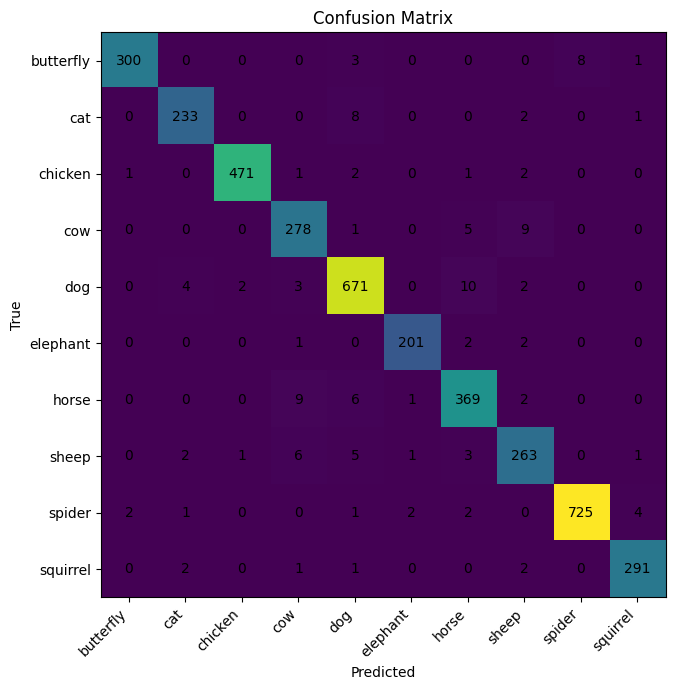

In [13]:
# ============================================
# ONE-CELL: Load model → Evaluate per-class/overall accuracy → Save CSV
# ============================================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ---------- Config ----------
MODEL_PATH = "models/ResNet50_animals.keras"
DATA_DIR   = "data/raw-img"          # gốc các thư mục lớp
IMG_SIZE   = (224, 224)
BATCH_SIZE = 16
SEED       = 2058

# ---------- 1) Load model ----------
model = keras.models.load_model(MODEL_PATH)
print(f"Loaded model from: {MODEL_PATH}")

# ---------- 2) Class names (đọc từ thư mục để có tên thật) ----------
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(class_names)
print("Class names:", class_names)

# ---------- 3) Chuẩn bị test_dt ----------
def build_test_dataset_from_dir():
    # Tạo dataset 70/30, rồi tách 1/2 của 30% làm test (giống cách đã dùng trước)
    full_val = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.3,
        subset="validation",
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical"   # giữ one-hot
    )
    # tách nửa làm test
    n = tf.data.experimental.cardinality(full_val)
    test_dt = full_val.take(n // 2)
    return test_dt

if "test_dt" in globals():
    print("Using existing test_dt from notebook.")
    _test_dt = test_dt
else:
    print("test_dt not found → building from directory…")
    _test_dt = build_test_dataset_from_dir()

# để tăng tốc chạy
_test_dt = _test_dt.prefetch(tf.data.AUTOTUNE)

# ---------- 4) Thu labels & preds ----------
y_true_list, y_pred_prob_list = [], []
for imgs, labels in _test_dt:
    # labels có thể là one-hot hoặc int; chuẩn hóa về int
    if labels.shape.rank > 1 and labels.shape[-1] == num_classes:
        y_true_list.append(np.argmax(labels.numpy(), axis=1))
    else:
        y_true_list.append(labels.numpy().astype(int).ravel())
    preds = model.predict(imgs, verbose=0)
    y_pred_prob_list.append(preds)

y_true = np.concatenate(y_true_list)
y_prob = np.concatenate(y_pred_prob_list)
y_pred = np.argmax(y_prob, axis=1)

# ---------- 5) Chỉ số tổng hợp ----------
overall_acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

# per-class accuracy (tỷ lệ đúng trong từng lớp thật sự)
per_class_acc = []
support = []
for k in range(num_classes):
    idx = (y_true == k)
    support_k = int(idx.sum())
    support.append(support_k)
    if support_k == 0:
        per_class_acc.append(np.nan)
    else:
        per_class_acc.append(float((y_pred[idx] == y_true[idx]).mean()))

summary_df = pd.DataFrame({
    "Class": class_names,
    "Samples": support,
    "Accuracy": per_class_acc,
    "Precision": [report[c]["precision"] for c in class_names],
    "Recall":    [report[c]["recall"]    for c in class_names],
    "F1-Score":  [report[c]["f1-score"]  for c in class_names],
})

summary_df.loc[len(summary_df)] = [
    "OVERALL", int(len(y_true)), float(overall_acc),
    report["weighted avg"]["precision"],
    report["weighted avg"]["recall"],
    report["weighted avg"]["f1-score"],
]

print(f"\nOverall accuracy: {overall_acc:.4f}\n")
display(summary_df.round(4))

# ---------- 6) Lưu CSV ----------
OUT_CSV = "test_class_accuracy_summary.csv"
summary_df.to_csv(OUT_CSV, index=False)
print(f"Saved summary to {OUT_CSV}")

# ---------- 7) Confusion matrix ----------
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


In [14]:
# ============================================
# XUẤT FILE TXT: train_list, val_list, test_list
# ============================================
import os, random, math, pathlib

# -------- Config --------
DATA_DIR = "data/raw-img"
TRAIN_DIR = "train"
CV_DIR = "cv"
TEST_DIR = "test"
SPLIT = (0.7, 0.15, 0.15)  # train, val, test
SEED = 2058
random.seed(SEED)

# -------- Helper --------
def list_all_images(base_dir):
    exts = (".jpg", ".jpeg", ".png", ".bmp")
    files = []
    for cls in sorted(os.listdir(base_dir)):
        class_dir = os.path.join(base_dir, cls)
        if not os.path.isdir(class_dir):
            continue
        imgs = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith(exts)]
        files.extend(imgs)
    return files

# -------- Split --------
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(CV_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

train_list, val_list, test_list = [], [], []

for cls in sorted(os.listdir(DATA_DIR)):
    class_dir = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(class_dir):
        continue

    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * SPLIT[0])
    n_val = int(n_total * SPLIT[1])

    train_list.extend(images[:n_train])
    val_list.extend(images[n_train:n_train + n_val])
    test_list.extend(images[n_train + n_val:])

print(f"✅ Tổng số ảnh: {len(train_list)+len(val_list)+len(test_list)}")
print(f" - Train: {len(train_list)}")
print(f" - Val  : {len(val_list)}")
print(f" - Test : {len(test_list)}")

# -------- Ghi file --------
def write_list(file_path, data):
    with open(file_path, "w", encoding="utf-8") as f:
        for p in data:
            f.write(f"{os.path.abspath(p)}\n")

write_list(os.path.join(TRAIN_DIR, "train_list.txt"), train_list)
write_list(os.path.join(CV_DIR, "val_list.txt"), val_list)
write_list(os.path.join(TEST_DIR, "test_list.txt"), test_list)

print("\n📄 Đã tạo các file:")
print(" -", os.path.abspath(os.path.join(TRAIN_DIR, "train_list.txt")))
print(" -", os.path.abspath(os.path.join(CV_DIR, "val_list.txt")))
print(" -", os.path.abspath(os.path.join(TEST_DIR, "test_list.txt")))


✅ Tổng số ảnh: 26179
 - Train: 18322
 - Val  : 3922
 - Test : 3935

📄 Đã tạo các file:
 - /mnt/d/7.JupyterNoteBook/Models/Recognize_animals/train/train_list.txt
 - /mnt/d/7.JupyterNoteBook/Models/Recognize_animals/cv/val_list.txt
 - /mnt/d/7.JupyterNoteBook/Models/Recognize_animals/test/test_list.txt
